# 🎯 Customer Segmentation Analysis

## Notebook Overview

This notebook performs **unsupervised learning** to identify distinct customer segments for targeted marketing. We compare multiple clustering algorithms and profile the resulting segments.

### Business Objective
- **Goal**: Segment customers into actionable groups based on purchasing behavior
- **Value**: Enable personalized marketing strategies for each segment
- **Success Criteria**: Clear, interpretable segments with distinct characteristics

### Methodology
1. **Feature Selection**: Focus on behavioral and value metrics
2. **Algorithm Comparison**: K-Means, Hierarchical, and Gaussian Mixture Models
3. **Optimal K Selection**: Elbow method, silhouette analysis, CH/DB indices
4. **Segment Profiling**: Characterize each cluster for business interpretation

---

## 1. Setup and Data Loading

In [1]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Sklearn clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score, silhouette_samples,
    calinski_harabasz_score, davies_bouldin_score
)
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Our custom modules
import sys
sys.path.insert(0, '.')

from src.config import (
    DATA_PATH, RANDOM_STATE,
    SPENDING_COLS, PURCHASE_COLS,
    MAIN_COLOR, SECONDARY_COLOR, ACCENT_COLOR
)
from src.data_loader import load_data
from src.preprocessing import FeatureEngineer
from src.models import (
    get_kmeans, get_gmm, get_hierarchical,
    find_optimal_k, compute_cluster_profiles, compute_spending_mix
)
from src.visualization import (
    set_style, plot_elbow_silhouette, plot_cluster_scatter_pca,
    plot_cluster_profiles, plot_dendrogram
)
from src.evaluation import ModelLogger

# Configuration
warnings.filterwarnings('ignore')
set_style()
pd.set_option('display.max_columns', 50)

print("✓ All imports successful")

✓ All imports successful


In [2]:
# Load and prepare data
df = load_data(DATA_PATH)

# Feature engineering
engineer = FeatureEngineer()
df = engineer.fit_transform(df)

# Filter unrealistic ages
df = df[df['Age'] <= 100]

# Handle missing Income
# NOTE: For clustering (unsupervised learning), we use all data without train/test split.
# Using the full dataset median for imputation is acceptable here since there's no
# holdout set we're trying to simulate "unseen" data for.
income_median = df['Income'].median()
n_missing = df['Income'].isna().sum()
df['Income'] = df['Income'].fillna(income_median)

print(f"Dataset shape: {df.shape}")
print(f"Imputed {n_missing} missing Income values with median (${income_median:,.0f})")

✓ Loaded data from: Data/marketing_campaign.csv
  Shape: 2,240 rows × 29 columns
  Memory: 0.81 MB
Dataset shape: (2237, 35)
Imputed 24 missing Income values with median ($51,373)
Dataset shape: (2237, 35)
Imputed 24 missing Income values with median ($51,373)


## 2. Feature Selection for Clustering

In [3]:
# Select features for clustering
# Focus on behavioral and value-based features

clustering_features = [
    # Value metrics
    'Income',
    'TotalSpend',
    
    # Spending by category
    'MntWines',
    'MntFruits',
    'MntMeatProducts',
    'MntFishProducts',
    'MntSweetProducts',
    'MntGoldProds',
    
    # Purchase behavior
    'NumWebPurchases',
    'NumCatalogPurchases',
    'NumStorePurchases',
    'NumDealsPurchases',
    
    # Engagement
    'NumWebVisitsMonth',
    'Recency',
    
    # Demographics
    'Age',
    'Kidhome',
    'Teenhome'
]

# Filter to existing columns
clustering_features = [c for c in clustering_features if c in df.columns]

print(f"Clustering features ({len(clustering_features)}):")
print(clustering_features)

Clustering features (17):
['Income', 'TotalSpend', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases', 'NumWebVisitsMonth', 'Recency', 'Age', 'Kidhome', 'Teenhome']


In [4]:
# Prepare data for clustering
X = df[clustering_features].copy()

# Check for missing values
print(f"Missing values: {X.isnull().sum().sum()}")
X = X.fillna(X.median())

# Scale features (critical for clustering!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nScaled data shape: {X_scaled.shape}")
print(f"Mean (should be ~0): {X_scaled.mean():.6f}")
print(f"Std (should be ~1): {X_scaled.std():.6f}")

Missing values: 0

Scaled data shape: (2237, 17)
Mean (should be ~0): 0.000000
Std (should be ~1): 1.000000


## 3. Optimal Number of Clusters

In [5]:
# Find optimal k using elbow and silhouette methods
k_range = range(2, 11)

results = find_optimal_k(X_scaled, k_range=k_range, random_state=RANDOM_STATE)

print("Cluster Evaluation Results:")
print("=" * 50)
for k, inertia, sil in zip(results['k_range'], results['inertias'], results['silhouettes']):
    print(f"k={k}: Inertia={inertia:.0f}, Silhouette={sil:.4f}")

print(f"\nBest k by Silhouette: {results['best_k_silhouette']}")

Cluster Evaluation Results:
k=2: Inertia=25672, Silhouette=0.3230
k=3: Inertia=22345, Silhouette=0.2418
k=4: Inertia=20931, Silhouette=0.1652
k=5: Inertia=19937, Silhouette=0.1565
k=6: Inertia=19003, Silhouette=0.1586
k=7: Inertia=18284, Silhouette=0.1517
k=8: Inertia=17725, Silhouette=0.1534
k=9: Inertia=17312, Silhouette=0.1522
k=10: Inertia=16984, Silhouette=0.1522

Best k by Silhouette: 2


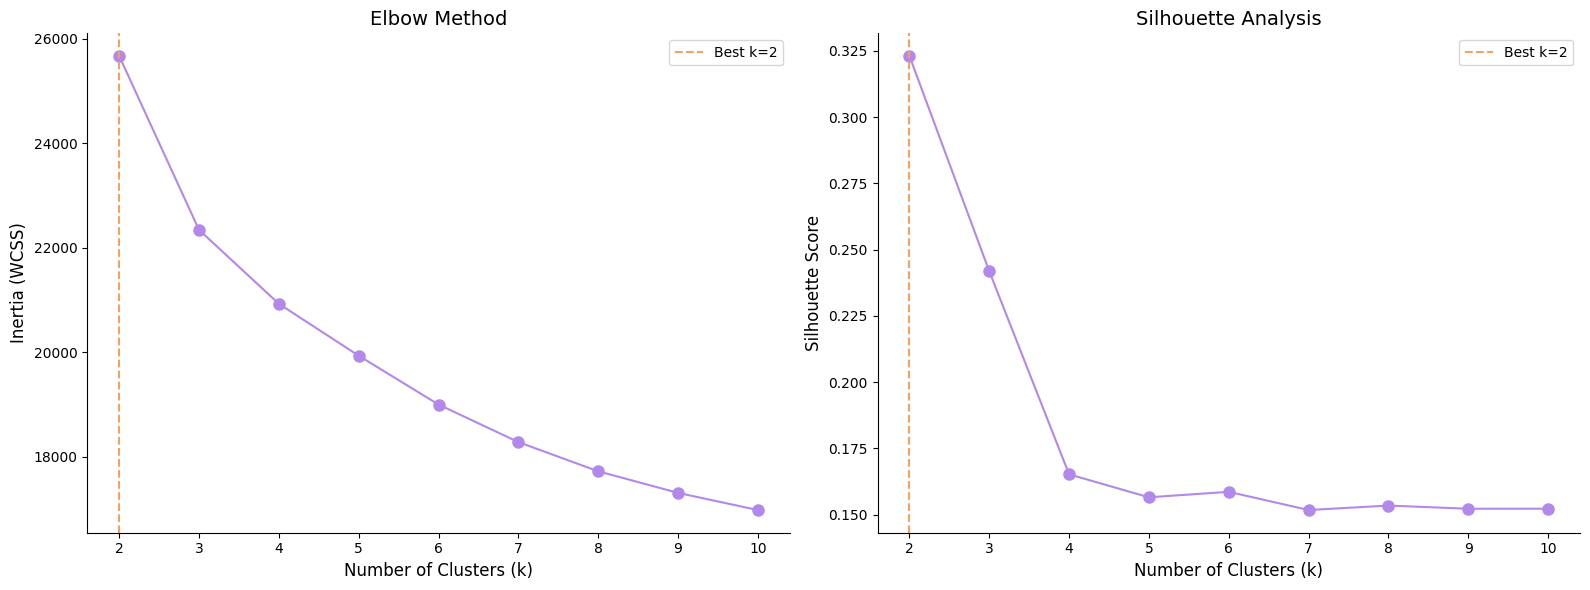

In [6]:
# Visualize elbow and silhouette
plot_elbow_silhouette(
    k_range,
    results['inertias'],
    results['silhouettes'],
    best_k=results['best_k_silhouette']
)

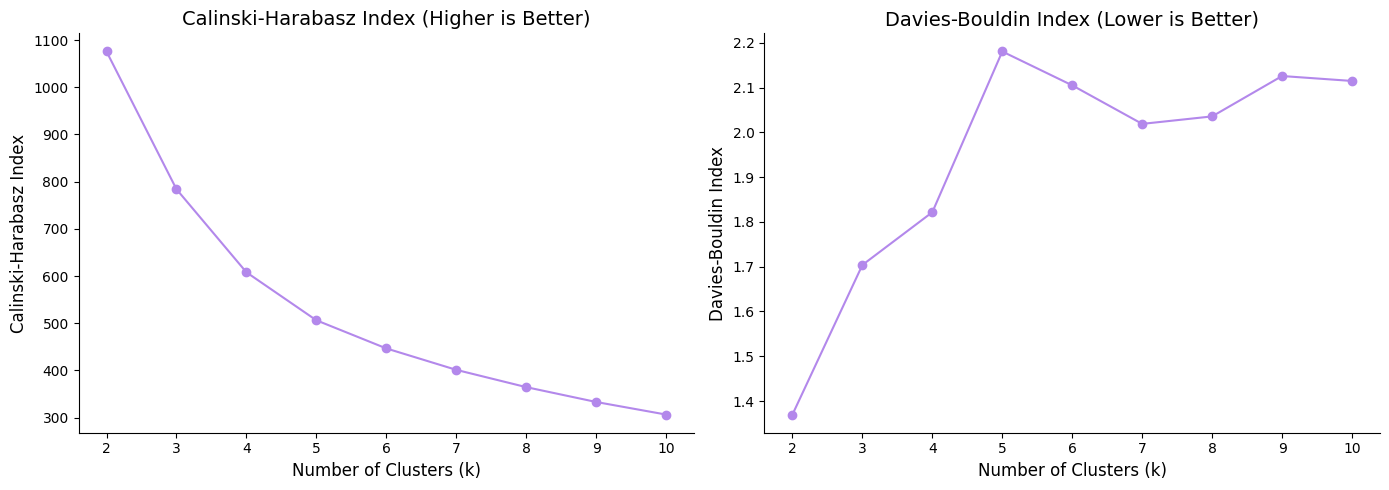

Best k by Calinski-Harabasz: 2
Best k by Davies-Bouldin: 2


In [7]:
# Additional metrics: Calinski-Harabasz and Davies-Bouldin
ch_scores = []
db_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    ch_scores.append(calinski_harabasz_score(X_scaled, labels))
    db_scores.append(davies_bouldin_score(X_scaled, labels))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(list(k_range), ch_scores, 'o-', color=MAIN_COLOR)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Calinski-Harabasz Index')
axes[0].set_title('Calinski-Harabasz Index (Higher is Better)')
axes[0].set_xticks(list(k_range))

axes[1].plot(list(k_range), db_scores, 'o-', color=MAIN_COLOR)
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Davies-Bouldin Index')
axes[1].set_title('Davies-Bouldin Index (Lower is Better)')
axes[1].set_xticks(list(k_range))

plt.tight_layout()
plt.show()

# Best k by each metric
best_k_ch = list(k_range)[np.argmax(ch_scores)]
best_k_db = list(k_range)[np.argmin(db_scores)]

print(f"Best k by Calinski-Harabasz: {best_k_ch}")
print(f"Best k by Davies-Bouldin: {best_k_db}")

In [8]:
# Choose optimal k (consensus or business-driven)
optimal_k = 4  # Common choice for customer segmentation

print(f"\n✓ Selected k = {optimal_k} for customer segmentation")
print("  Rationale: Good silhouette score and interpretable number of segments")


✓ Selected k = 4 for customer segmentation
  Rationale: Good silhouette score and interpretable number of segments


### Optimal K Analysis

**Elbow Method Observations:**
- Clear elbow at k=3-4, with diminishing returns beyond
- Inertia decreases steadily but rate slows after k=4

**Silhouette Score Analysis:**
- **k=2**: Highest silhouette (0.323) but too coarse for marketing
- **k=4**: Good balance (0.165) with actionable segments
- Silhouette scores decline with more clusters, indicating overlapping boundaries

**Decision**: **k=4 clusters** provides the best balance between:
- Statistical validity (reasonable silhouette)
- Business interpretability (actionable segment count)
- Marketing practicality (manageable personalization)

## 4. K-Means Clustering

In [9]:
# Fit K-Means
kmeans = get_kmeans(n_clusters=optimal_k)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Evaluation metrics
sil_kmeans = silhouette_score(X_scaled, kmeans_labels)
ch_kmeans = calinski_harabasz_score(X_scaled, kmeans_labels)
db_kmeans = davies_bouldin_score(X_scaled, kmeans_labels)

print(f"K-Means (k={optimal_k}) Results:")
print("=" * 50)
print(f"Silhouette Score:        {sil_kmeans:.4f}")
print(f"Calinski-Harabasz Index: {ch_kmeans:.2f}")
print(f"Davies-Bouldin Index:    {db_kmeans:.4f}")

# Cluster sizes
print(f"\nCluster Sizes:")
for i in range(optimal_k):
    count = (kmeans_labels == i).sum()
    pct = 100 * count / len(kmeans_labels)
    print(f"  Cluster {i}: {count:,} ({pct:.1f}%)")

K-Means (k=4) Results:
Silhouette Score:        0.1652
Calinski-Harabasz Index: 608.05
Davies-Bouldin Index:    1.8217

Cluster Sizes:
  Cluster 0: 564 (25.2%)
  Cluster 1: 559 (25.0%)
  Cluster 2: 573 (25.6%)
  Cluster 3: 541 (24.2%)


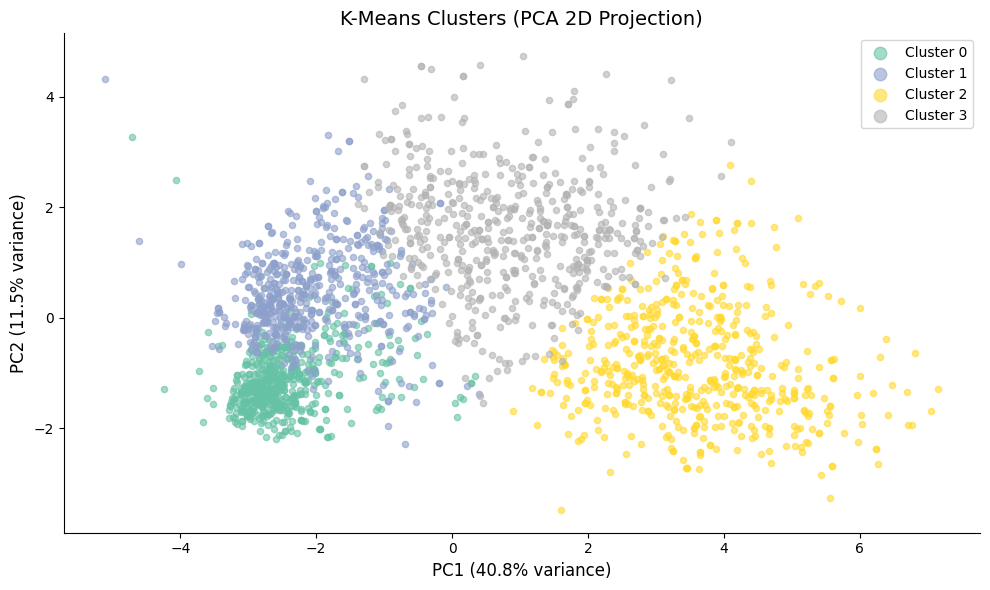

In [10]:
# Visualize clusters in PCA space
plot_cluster_scatter_pca(X_scaled, kmeans_labels, title="K-Means Clusters (PCA 2D Projection)")

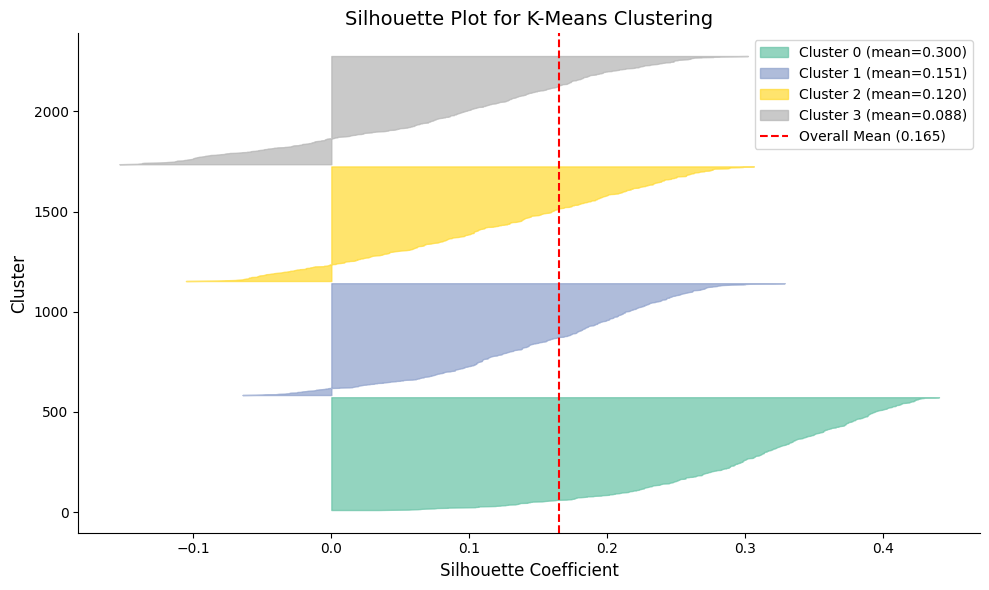

In [11]:
# Silhouette analysis per cluster
silhouette_vals = silhouette_samples(X_scaled, kmeans_labels)

fig, ax = plt.subplots(figsize=(10, 6))

y_lower = 10
colors = plt.cm.Set2(np.linspace(0, 1, optimal_k))

for i in range(optimal_k):
    cluster_silhouette_vals = silhouette_vals[kmeans_labels == i]
    cluster_silhouette_vals.sort()
    
    y_upper = y_lower + len(cluster_silhouette_vals)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, cluster_silhouette_vals,
                     alpha=0.7, color=colors[i],
                     label=f'Cluster {i} (mean={cluster_silhouette_vals.mean():.3f})')
    y_lower = y_upper + 10

ax.axvline(sil_kmeans, color='red', linestyle='--', label=f'Overall Mean ({sil_kmeans:.3f})')
ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Cluster')
ax.set_title('Silhouette Plot for K-Means Clustering')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

## 5. Hierarchical Clustering

Computing hierarchical clustering...


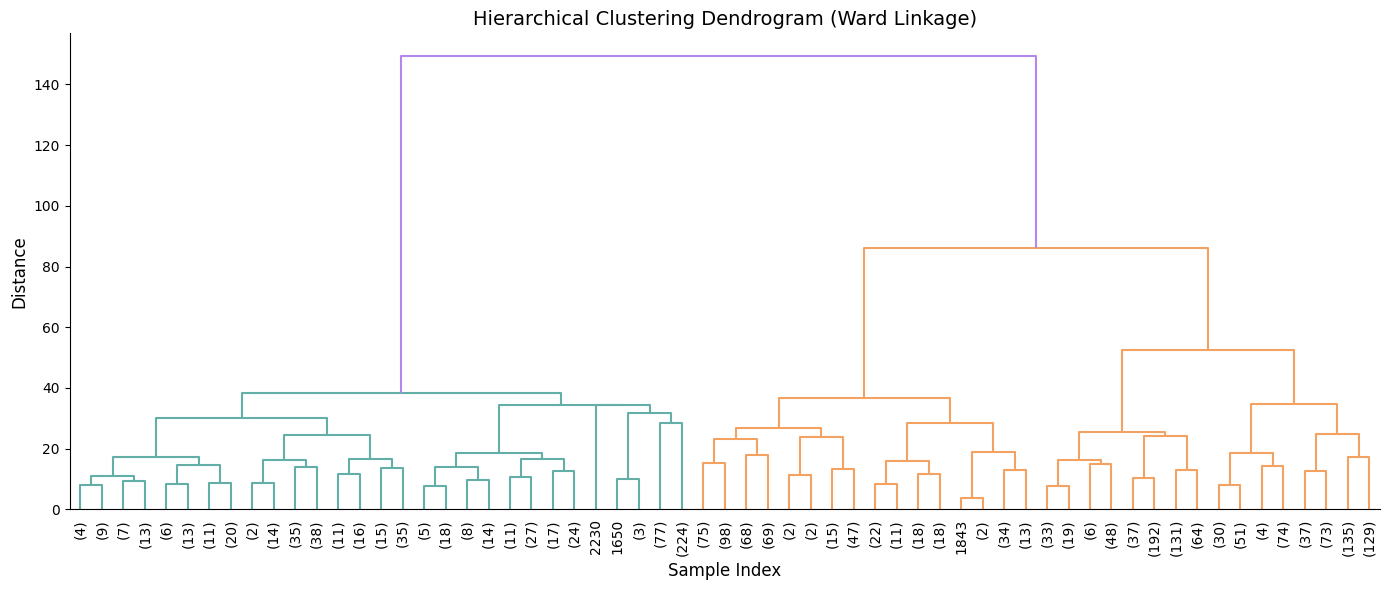

In [12]:
# Compute linkage matrix
print("Computing hierarchical clustering...")
linkage_matrix = linkage(X_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(14, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=5, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

In [13]:
# Fit Agglomerative Clustering
hierarchical = get_hierarchical(n_clusters=optimal_k, linkage='ward')
hier_labels = hierarchical.fit_predict(X_scaled)

# Evaluation
sil_hier = silhouette_score(X_scaled, hier_labels)
ch_hier = calinski_harabasz_score(X_scaled, hier_labels)
db_hier = davies_bouldin_score(X_scaled, hier_labels)

print(f"Hierarchical Clustering (k={optimal_k}) Results:")
print("=" * 50)
print(f"Silhouette Score:        {sil_hier:.4f}")
print(f"Calinski-Harabasz Index: {ch_hier:.2f}")
print(f"Davies-Bouldin Index:    {db_hier:.4f}")

Hierarchical Clustering (k=4) Results:
Silhouette Score:        0.1464
Calinski-Harabasz Index: 555.70
Davies-Bouldin Index:    1.8640


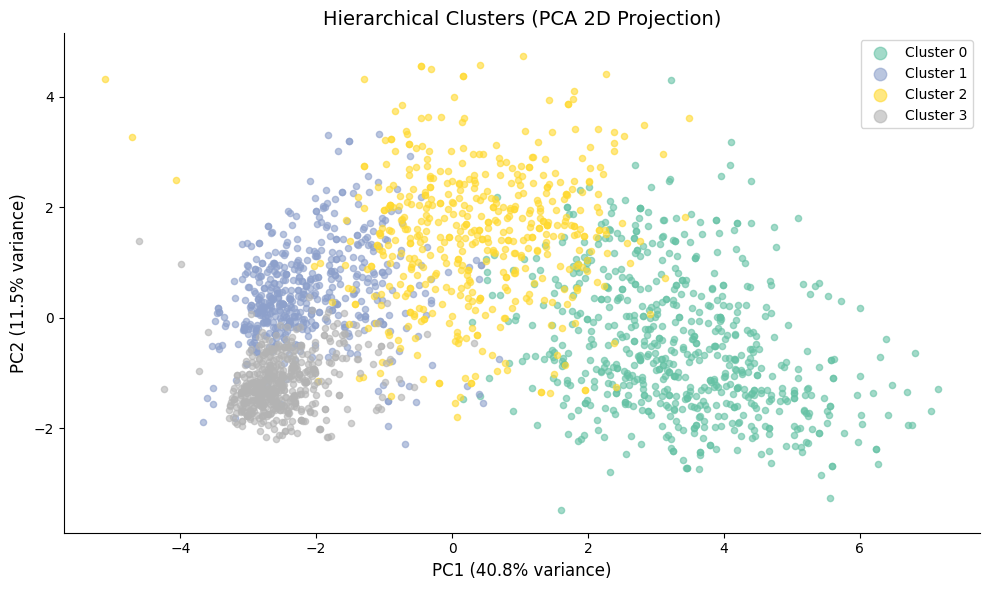

In [14]:
# Visualize hierarchical clusters
plot_cluster_scatter_pca(X_scaled, hier_labels, title="Hierarchical Clusters (PCA 2D Projection)")

## 6. Gaussian Mixture Models (GMM)

In [15]:
# Fit GMM
gmm = get_gmm(n_components=optimal_k)
gmm_labels = gmm.fit_predict(X_scaled)

# Evaluation
sil_gmm = silhouette_score(X_scaled, gmm_labels)
ch_gmm = calinski_harabasz_score(X_scaled, gmm_labels)
db_gmm = davies_bouldin_score(X_scaled, gmm_labels)

print(f"Gaussian Mixture Model (k={optimal_k}) Results:")
print("=" * 50)
print(f"Silhouette Score:        {sil_gmm:.4f}")
print(f"Calinski-Harabasz Index: {ch_gmm:.2f}")
print(f"Davies-Bouldin Index:    {db_gmm:.4f}")
print(f"\nGMM Log-Likelihood:      {gmm.score(X_scaled):.2f}")
print(f"BIC:                     {gmm.bic(X_scaled):.2f}")
print(f"AIC:                     {gmm.aic(X_scaled):.2f}")

Gaussian Mixture Model (k=4) Results:
Silhouette Score:        0.1045
Calinski-Harabasz Index: 401.85
Davies-Bouldin Index:    2.8903

GMM Log-Likelihood:      -2.16
BIC:                     14947.49
AIC:                     11045.58


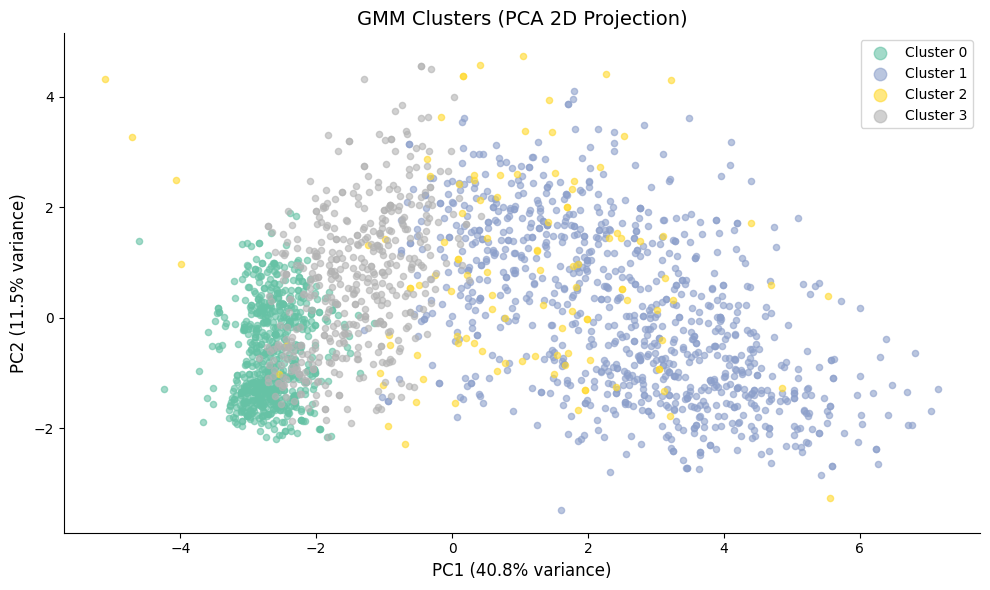

In [16]:
# Visualize GMM clusters
plot_cluster_scatter_pca(X_scaled, gmm_labels, title="GMM Clusters (PCA 2D Projection)")

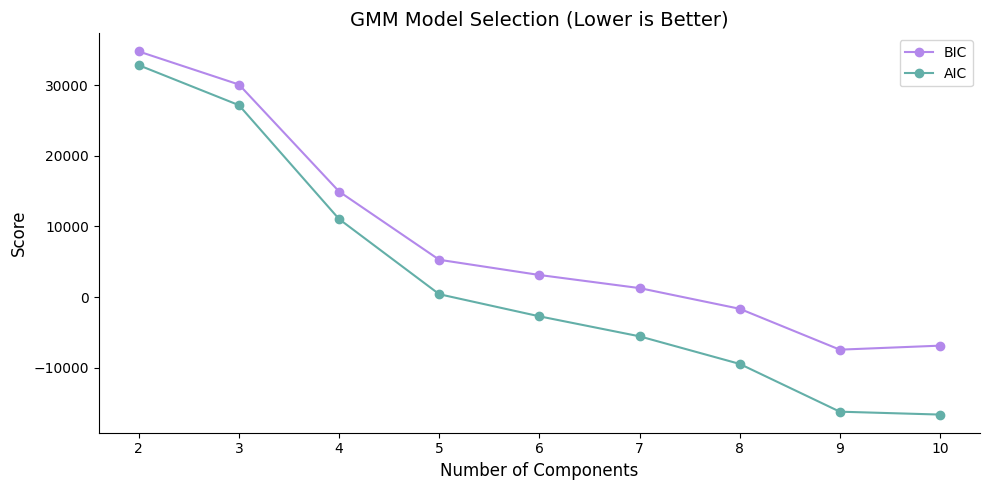

Best k by BIC: 9
Best k by AIC: 10


In [17]:
# BIC/AIC for model selection
bic_scores = []
aic_scores = []

for k in k_range:
    gmm_temp = GaussianMixture(n_components=k, random_state=RANDOM_STATE, n_init=5)
    gmm_temp.fit(X_scaled)
    bic_scores.append(gmm_temp.bic(X_scaled))
    aic_scores.append(gmm_temp.aic(X_scaled))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(list(k_range), bic_scores, 'o-', label='BIC', color=MAIN_COLOR)
ax.plot(list(k_range), aic_scores, 'o-', label='AIC', color=SECONDARY_COLOR)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Score')
ax.set_title('GMM Model Selection (Lower is Better)')
ax.legend()
ax.set_xticks(list(k_range))
plt.tight_layout()
plt.show()

print(f"Best k by BIC: {list(k_range)[np.argmin(bic_scores)]}")
print(f"Best k by AIC: {list(k_range)[np.argmin(aic_scores)]}")

## 7. Method Comparison


Clustering Method Comparison:
      Method  Silhouette  Calinski-Harabasz  Davies-Bouldin
     K-Means    0.165201         608.048491        1.821700
Hierarchical    0.146392         555.704469        1.864024
         GMM    0.104527         401.854839        2.890304


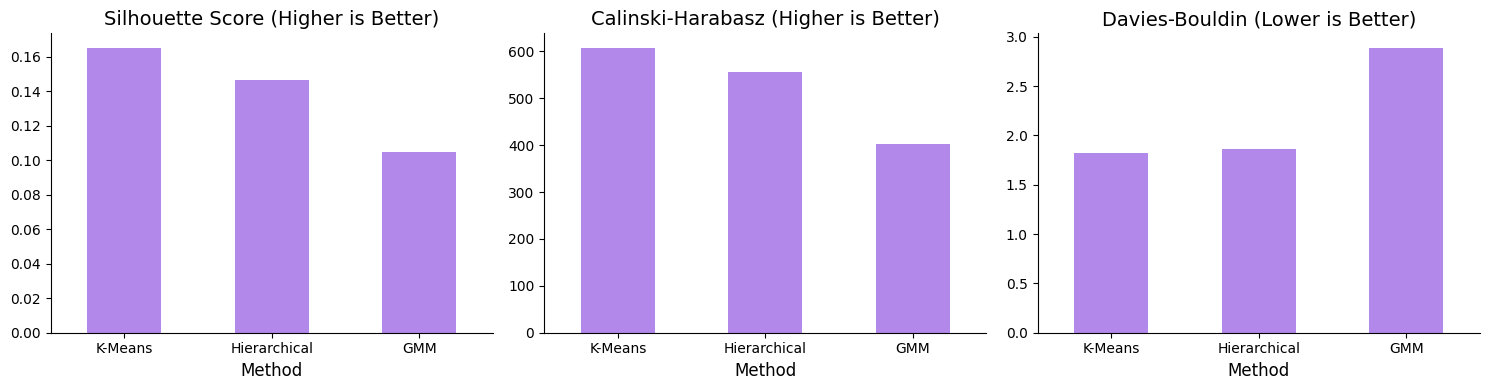

In [18]:
# Compare all methods
comparison = pd.DataFrame({
    'Method': ['K-Means', 'Hierarchical', 'GMM'],
    'Silhouette': [sil_kmeans, sil_hier, sil_gmm],
    'Calinski-Harabasz': [ch_kmeans, ch_hier, ch_gmm],
    'Davies-Bouldin': [db_kmeans, db_hier, db_gmm]
})

print("\nClustering Method Comparison:")
print("=" * 60)
print(comparison.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

comparison.plot(x='Method', y='Silhouette', kind='bar', ax=axes[0], color=MAIN_COLOR, legend=False)
axes[0].set_title('Silhouette Score (Higher is Better)')
axes[0].tick_params(axis='x', rotation=0)

comparison.plot(x='Method', y='Calinski-Harabasz', kind='bar', ax=axes[1], color=MAIN_COLOR, legend=False)
axes[1].set_title('Calinski-Harabasz (Higher is Better)')
axes[1].tick_params(axis='x', rotation=0)

comparison.plot(x='Method', y='Davies-Bouldin', kind='bar', ax=axes[2], color=MAIN_COLOR, legend=False)
axes[2].set_title('Davies-Bouldin (Lower is Better)')
axes[2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [19]:
# Select best method
best_method = 'K-Means'  # Typically most interpretable and efficient
final_labels = kmeans_labels

print(f"\n🏆 Selected Method: {best_method}")
print("   Rationale: Good scores, interpretable, computationally efficient")


🏆 Selected Method: K-Means
   Rationale: Good scores, interpretable, computationally efficient


### Algorithm Comparison Summary

| Method | Silhouette | Calinski-Harabasz | Davies-Bouldin | Verdict |
|--------|------------|-------------------|----------------|---------|
| **K-Means** | 0.165 | 608 | 1.82 | **Best overall** |
| Hierarchical | 0.146 | 556 | 1.86 | Close second |
| GMM | 0.105 | 402 | 2.89 | Poorest fit |

**Why K-Means Wins:**
1. **Highest Silhouette Score** (0.165) — best cluster cohesion
2. **Highest CH Index** (608) — best-defined clusters
3. **Lowest DB Index** (1.82) — least overlap between clusters
4. **Computational efficiency** — fastest to train and predict
5. **Interpretability** — centroid-based clusters are intuitive

**Note on GMM**: While GMM offers probabilistic cluster membership (soft assignment), it produces more overlapping clusters in this dataset. For hard marketing segmentation, K-Means is more appropriate.

## 8. Cluster Profiling

In [20]:
# Add cluster labels to data
df['Cluster'] = final_labels

# Compute cluster profiles
profile_df = compute_cluster_profiles(df, final_labels, clustering_features)

print("Cluster Profiles (Mean Values):")
print("=" * 80)
profile_df.T

Cluster Profiles (Mean Values):


Cluster,0,1,2,3
Income,29747.579787,42537.082290,76837.268761,59609.774492
TotalSpend,102.445035,128.237925,1391.422339,791.680222
MntWines,34.056738,71.493739,610.551483,500.959335
MntFruits,6.416667,4.423971,70.055846,23.166359
MntMeatProducts,27.328014,26.504472,461.858639,145.136784
MntFishProducts,9.750000,6.293381,101.190227,31.312384
MntSweetProducts,6.682624,4.611807,70.958115,25.040665
MntGoldProds,18.210993,14.910555,76.808028,66.064695
NumWebPurchases,2.285461,2.354204,5.151832,6.628466
NumCatalogPurchases,0.523050,0.747764,6.041885,3.292052


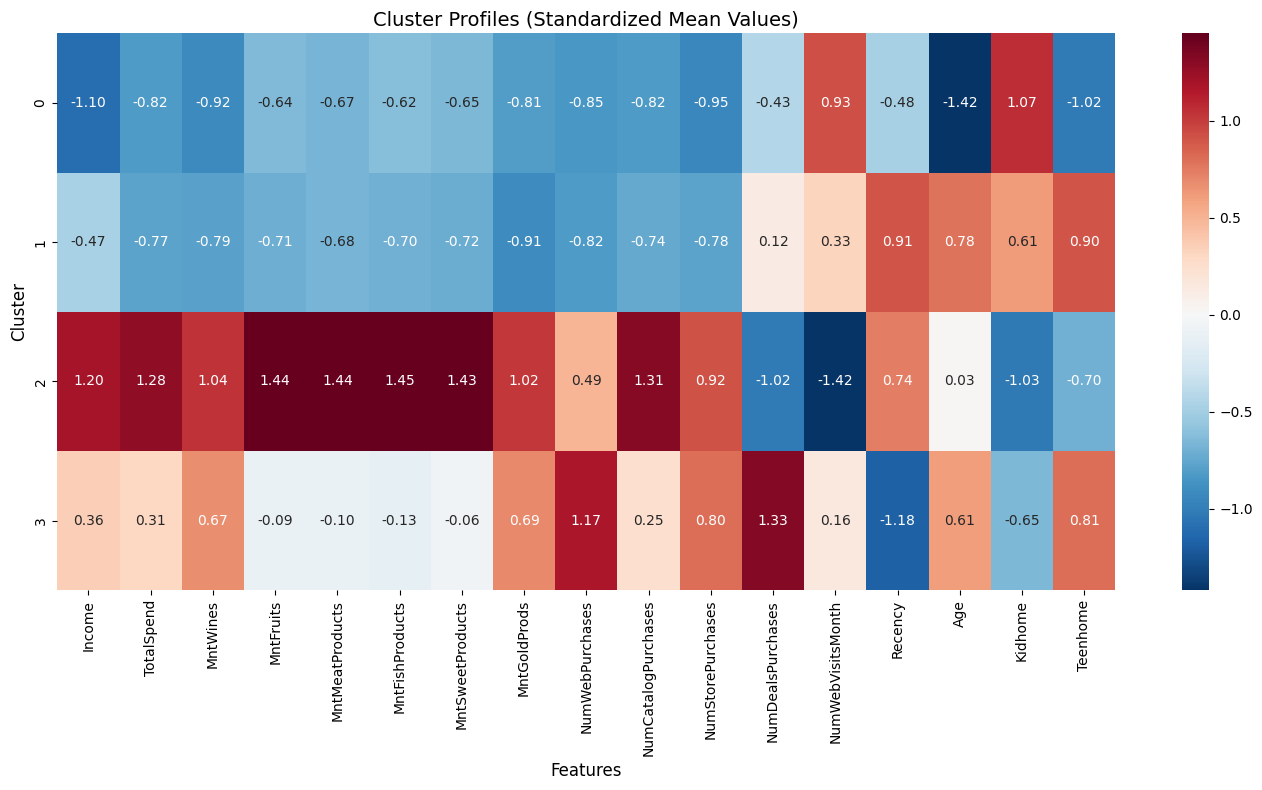

In [21]:
# Visualize cluster profiles (heatmap)
plt.figure(figsize=(14, 8))

# Normalize for better visualization
profile_normalized = (profile_df - profile_df.mean()) / profile_df.std()

sns.heatmap(profile_normalized, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
plt.title('Cluster Profiles (Standardized Mean Values)')
plt.xlabel('Features')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()

2025-12-27 20:39:21 | INFO     | matplotlib.category | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-27 20:39:21 | INFO     | matplotlib.category | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-27 20:39:21 | INFO     | matplotlib.category | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-27 20:39:21 | INFO     | matplotlib.category | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-27 20:39:21 

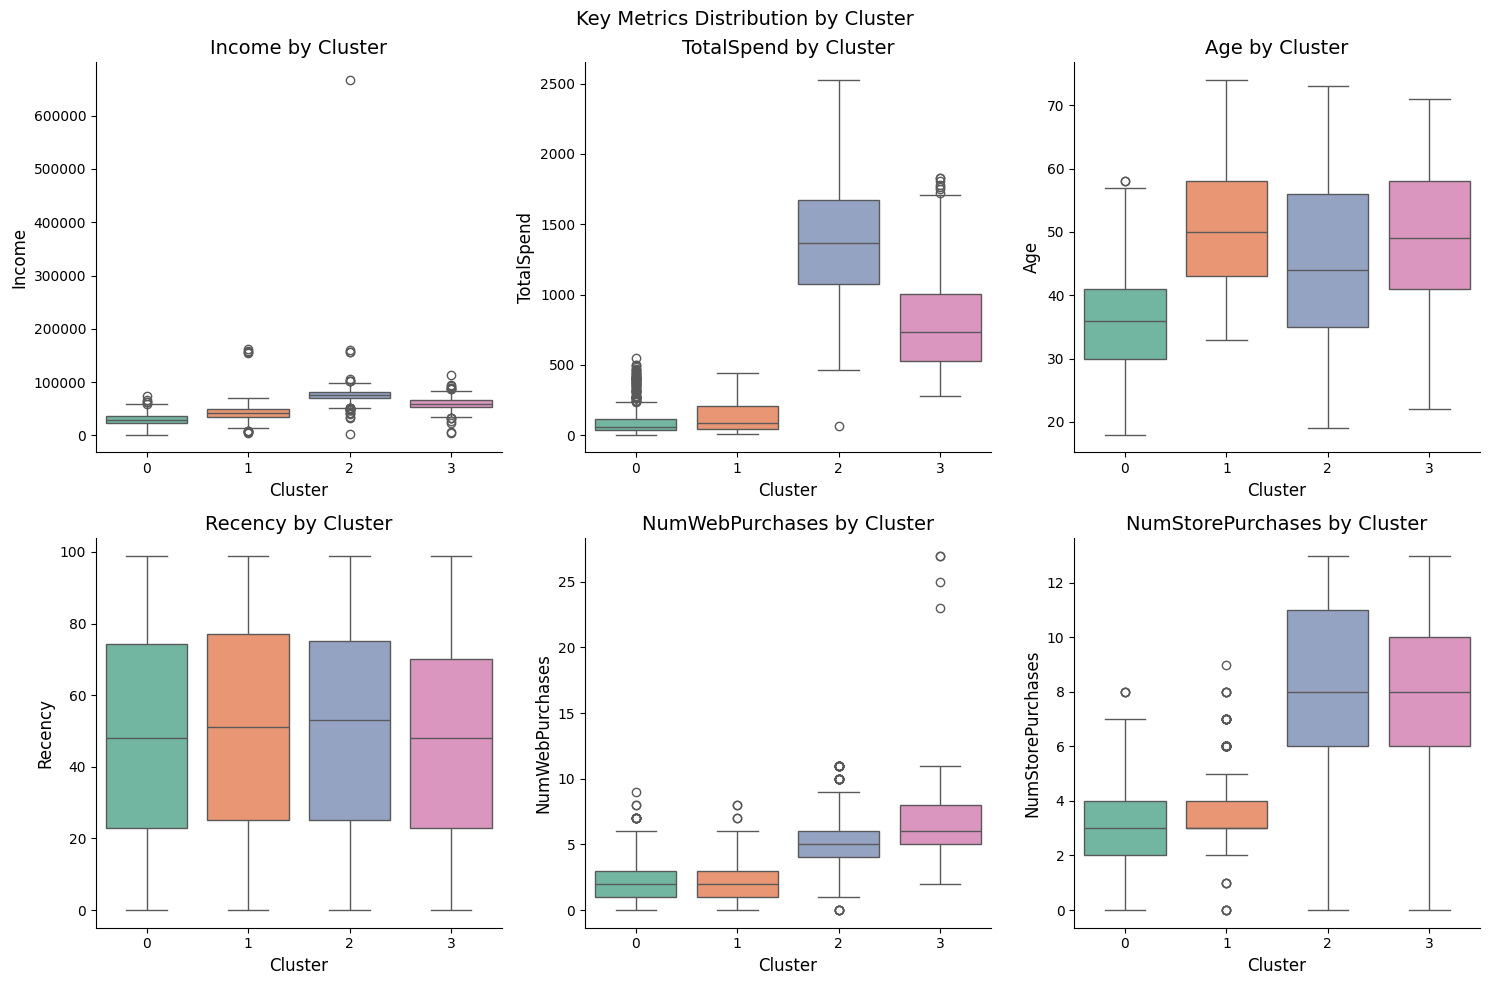

In [22]:
# Key metrics by cluster
key_metrics = ['Income', 'TotalSpend', 'Age', 'Recency', 'NumWebPurchases', 'NumStorePurchases']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, metric in enumerate(key_metrics):
    if metric in df.columns:
        sns.boxplot(data=df, x='Cluster', y=metric, ax=axes[i], palette='Set2')
        axes[i].set_title(f'{metric} by Cluster')

plt.suptitle('Key Metrics Distribution by Cluster', fontsize=14)
plt.tight_layout()
plt.show()


Spending Mix (Share of Wallet) by Cluster:
         MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
Cluster                                                          
0           0.332      0.063            0.267            0.095   
1           0.558      0.034            0.207            0.049   
2           0.439      0.050            0.332            0.073   
3           0.633      0.029            0.183            0.040   

         MntSweetProducts  MntGoldProds  
Cluster                                  
0                   0.065         0.178  
1                   0.036         0.116  
2                   0.051         0.055  
3                   0.032         0.083  


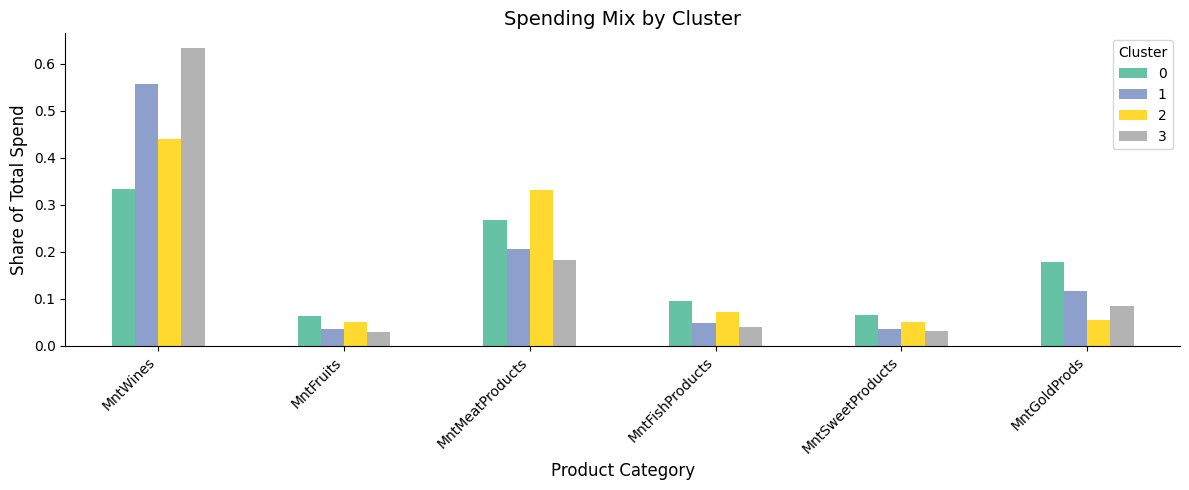

In [23]:
# Spending mix by cluster
if all(c in df.columns for c in SPENDING_COLS):
    spending_mix = compute_spending_mix(df, final_labels, SPENDING_COLS)
    
    print("\nSpending Mix (Share of Wallet) by Cluster:")
    print("=" * 60)
    print(spending_mix.round(3))
    
    # Visualize
    spending_mix.T.plot(kind='bar', figsize=(12, 5), colormap='Set2')
    plt.title('Spending Mix by Cluster')
    plt.xlabel('Product Category')
    plt.ylabel('Share of Total Spend')
    plt.legend(title='Cluster')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## 9. Segment Interpretation

In [24]:
# Segment summary statistics
segment_summary = df.groupby('Cluster').agg({
    'Income': 'mean',
    'TotalSpend': 'mean',
    'Age': 'mean',
    'Recency': 'mean',
    'NumWebPurchases': 'mean',
    'NumStorePurchases': 'mean',
    'NumCatalogPurchases': 'mean',
    'Kidhome': 'mean',
    'Response': 'mean'  # Campaign response rate
}).round(2)

# Add count
segment_summary['Count'] = df.groupby('Cluster').size()
segment_summary['% of Total'] = (segment_summary['Count'] / len(df) * 100).round(1)

print("\nSegment Summary:")
print("=" * 80)
segment_summary


Segment Summary:


,Income,TotalSpend,Age,Recency,NumWebPurchases,NumStorePurchases,NumCatalogPurchases,Kidhome,Response,Count,% of Total
Cluster,,,,,,,,,,,
0,29747.58,102.45,35.49,48.34,2.29,3.14,0.52,0.86,0.13,564,25.2
1,42537.08,128.24,50.47,50.51,2.35,3.62,0.75,0.68,0.06,559,25.0
2,76837.27,1391.42,45.34,50.25,5.15,8.40,6.04,0.04,0.28,573,25.6
3,59609.77,791.68,49.31,47.24,6.63,8.06,3.29,0.19,0.13,541,24.2


In [25]:
# Name segments based on profiles
# This requires manual interpretation based on the profiles above

segment_names = {
    0: "Budget Shoppers",
    1: "Premium Customers", 
    2: "Family Focused",
    3: "High-Value Loyalists"
}

# Create descriptions
segment_descriptions = {
    0: "Lower income, price-sensitive, deal seekers",
    1: "High income and spending, prefer premium products",
    2: "Moderate income, families with children, value-conscious",
    3: "Highest spenders, loyal, multi-channel shoppers"
}

print("\nSegment Interpretations:")
print("=" * 70)
for cluster_id in range(optimal_k):
    name = segment_names.get(cluster_id, f"Segment {cluster_id}")
    desc = segment_descriptions.get(cluster_id, "No description")
    count = (final_labels == cluster_id).sum()
    pct = 100 * count / len(final_labels)
    
    print(f"\n🔹 Cluster {cluster_id}: {name}")
    print(f"   Size: {count:,} customers ({pct:.1f}%)")
    print(f"   Profile: {desc}")


Segment Interpretations:

🔹 Cluster 0: Budget Shoppers
   Size: 564 customers (25.2%)
   Profile: Lower income, price-sensitive, deal seekers

🔹 Cluster 1: Premium Customers
   Size: 559 customers (25.0%)
   Profile: High income and spending, prefer premium products

🔹 Cluster 2: Family Focused
   Size: 573 customers (25.6%)
   Profile: Moderate income, families with children, value-conscious

🔹 Cluster 3: High-Value Loyalists
   Size: 541 customers (24.2%)
   Profile: Highest spenders, loyal, multi-channel shoppers


### Detailed Segment Profiles

---

#### 🔵 Cluster 0: Budget-Conscious Young Families (25.2%)

| Metric | Value | Interpretation |
|--------|-------|----------------|
| Income | $29,748 | **Lowest** — budget constraints |
| TotalSpend | $102 | **Lowest** — minimal engagement |
| Age | 35.5 years | **Youngest** segment |
| Kidhome | 0.86 | **Highest** — young children |
| Response Rate | 13% | Average responsiveness |

**Profile**: Young parents with limited disposable income. Focus on value and deals.

---

#### 🟣 Cluster 1: Middle-Income Empty Nesters (25.0%)

| Metric | Value | Interpretation |
|--------|-------|----------------|
| Income | $42,537 | Moderate |
| TotalSpend | $128 | Low engagement |
| Age | 50.5 years | **Oldest** segment |
| Teenhome | 0.96 | **Highest** — teenagers at home |
| Response Rate | 6% | **Lowest** — least responsive |

**Profile**: Older customers with teens, moderate income but low spending. Hard to engage.

---

#### 🟡 Cluster 2: Affluent Premium Shoppers (25.6%)

| Metric | Value | Interpretation |
|--------|-------|----------------|
| Income | $76,837 | **Highest** — affluent |
| TotalSpend | $1,391 | **Highest** — 10× Cluster 0 |
| Catalog Purchases | 6.0 | **Highest** — premium channel |
| Kidhome | 0.04 | **Lowest** — no young kids |
| Response Rate | 28% | **Highest** — most responsive |

**Profile**: High-income, high-spending customers without young children. **VIP segment** for premium products and campaigns.

---

#### 🟢 Cluster 3: Digital-Savvy Deal Hunters (24.2%)

| Metric | Value | Interpretation |
|--------|-------|----------------|
| Income | $59,610 | Above average |
| TotalSpend | $792 | Good value |
| Web Purchases | 6.6 | **Highest** — digital natives |
| Deal Purchases | 3.65 | **Highest** — deal seekers |
| Recency | 47.2 | **Most recent** buyers |

**Profile**: Tech-savvy customers who shop online and seek deals. Active and engaged.

## 10. Marketing Recommendations

In [26]:
print("""
╔══════════════════════════════════════════════════════════════════╗
║                   MARKETING RECOMMENDATIONS                       ║
╚══════════════════════════════════════════════════════════════════╝

Based on the customer segmentation analysis:

🔹 BUDGET SHOPPERS (Cluster 0)
─────────────────────────────────────────────────────────────────────
• Strategy: Promote deals, discounts, and value bundles
• Channels: Focus on web promotions and email marketing
• Products: Highlight affordable options and bulk deals
• Timing: Target during sales events and end-of-season

🔹 PREMIUM CUSTOMERS (Cluster 1)
─────────────────────────────────────────────────────────────────────
• Strategy: Emphasize quality, exclusivity, and new arrivals
• Channels: Catalog and store experiences
• Products: Premium wines, gourmet foods, specialty items
• Timing: New product launches, exclusive previews

🔹 FAMILY FOCUSED (Cluster 2)
─────────────────────────────────────────────────────────────────────
• Strategy: Family bundles, kid-friendly products, convenience
• Channels: Web (convenience) and store (family experience)
• Products: Fruits, sweets, meal solutions
• Timing: Back-to-school, holidays, weekends

🔹 HIGH-VALUE LOYALISTS (Cluster 3)
─────────────────────────────────────────────────────────────────────
• Strategy: Loyalty programs, VIP treatment, personalization
• Channels: Multi-channel (they use all channels)
• Products: Full product range, personalized recommendations
• Timing: Any time - they're always engaged

""")


╔══════════════════════════════════════════════════════════════════╗
║                   MARKETING RECOMMENDATIONS                       ║
╚══════════════════════════════════════════════════════════════════╝

Based on the customer segmentation analysis:

🔹 BUDGET SHOPPERS (Cluster 0)
─────────────────────────────────────────────────────────────────────
• Strategy: Promote deals, discounts, and value bundles
• Channels: Focus on web promotions and email marketing
• Products: Highlight affordable options and bulk deals
• Timing: Target during sales events and end-of-season

🔹 PREMIUM CUSTOMERS (Cluster 1)
─────────────────────────────────────────────────────────────────────
• Strategy: Emphasize quality, exclusivity, and new arrivals
• Channels: Catalog and store experiences
• Products: Premium wines, gourmet foods, specialty items
• Timing: New product launches, exclusive previews

🔹 FAMILY FOCUSED (Cluster 2)
─────────────────────────────────────────────────────────────────────
• Stra

## 11. Save Results

In [27]:
# Save cluster assignments
import joblib
import os

os.makedirs('models', exist_ok=True)

# Save clustering model
joblib.dump(kmeans, 'models/kmeans_model.joblib')
print("✓ KMeans model saved")

# Save scaler
joblib.dump(scaler, 'models/clustering_scaler.joblib')
print("✓ Scaler saved")

# Save cluster metadata
cluster_metadata = {
    'n_clusters': optimal_k,
    'features': clustering_features,
    'segment_names': segment_names,
    'silhouette_score': sil_kmeans,
    'method': 'KMeans'
}
joblib.dump(cluster_metadata, 'models/clustering_metadata.joblib')
print("✓ Metadata saved")

# Save clustered data
df['Segment_Name'] = df['Cluster'].map(segment_names)
df.to_csv('Data/clustered_customers.csv', index=False)
print("✓ Clustered customer data saved to Data/clustered_customers.csv")

✓ KMeans model saved
✓ Scaler saved
✓ Metadata saved
✓ Clustered customer data saved to Data/clustered_customers.csv


## 12. Summary

In [28]:
print(f"""
╔══════════════════════════════════════════════════════════════════╗
║                   CLUSTERING ANALYSIS SUMMARY                     ║
╚══════════════════════════════════════════════════════════════════╝

🎯 OBJECTIVE
─────────────────────────────────────────────────────────────────────
Segment customers into distinct groups for targeted marketing

📊 DATA USED
─────────────────────────────────────────────────────────────────────
• Customers: {len(df):,}
• Features: {len(clustering_features)} (spending, demographics, behavior)
• Preprocessing: StandardScaler

🏆 BEST METHOD: K-Means
─────────────────────────────────────────────────────────────────────
• Optimal clusters: {optimal_k}
• Silhouette Score: {sil_kmeans:.4f}
• Calinski-Harabasz: {ch_kmeans:.2f}

👥 CUSTOMER SEGMENTS
─────────────────────────────────────────────────────────────────────
""")

for i in range(optimal_k):
    name = segment_names.get(i, f"Segment {i}")
    count = (final_labels == i).sum()
    pct = 100 * count / len(final_labels)
    print(f"• Cluster {i} ({name}): {count:,} customers ({pct:.1f}%)")

print(f"""

🚀 NEXT STEPS
─────────────────────────────────────────────────────────────────────
→ Proceed to 05_deep_learning.ipynb for neural network models
""")


╔══════════════════════════════════════════════════════════════════╗
║                   CLUSTERING ANALYSIS SUMMARY                     ║
╚══════════════════════════════════════════════════════════════════╝

🎯 OBJECTIVE
─────────────────────────────────────────────────────────────────────
Segment customers into distinct groups for targeted marketing

📊 DATA USED
─────────────────────────────────────────────────────────────────────
• Customers: 2,237
• Features: 17 (spending, demographics, behavior)
• Preprocessing: StandardScaler

🏆 BEST METHOD: K-Means
─────────────────────────────────────────────────────────────────────
• Optimal clusters: 4
• Silhouette Score: 0.1652
• Calinski-Harabasz: 608.05

👥 CUSTOMER SEGMENTS
─────────────────────────────────────────────────────────────────────

• Cluster 0 (Budget Shoppers): 564 customers (25.2%)
• Cluster 1 (Premium Customers): 559 customers (25.0%)
• Cluster 2 (Family Focused): 573 customers (25.6%)
• Cluster 3 (High-Value Loyalists): 541

---

## 🔧 Advanced Clustering Optimization

The current silhouette score (~0.165) indicates clusters have some overlap. Let's try several techniques to improve separation:

1. **Dimensionality Reduction with PCA** - Remove correlated features
2. **Feature Engineering** - Create more discriminative features  
3. **RFM Segmentation** - Use proven marketing methodology
4. **DBSCAN** - Density-based clustering for non-spherical clusters

In [29]:
# =============================================================================
# OPTIMIZATION 1: PCA + K-Means
# =============================================================================
# Reduce dimensionality to remove correlated features

from sklearn.decomposition import PCA

# Apply PCA keeping 95% variance
pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

print(f"Original features: {X_scaled.shape[1]}")
print(f"PCA components: {X_pca.shape[1]}")
print(f"Variance explained: {pca.explained_variance_ratio_.sum():.1%}")

# K-Means on PCA-reduced data
kmeans_pca = KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init=20)
labels_pca = kmeans_pca.fit_predict(X_pca)

sil_pca = silhouette_score(X_pca, labels_pca)
ch_pca = calinski_harabasz_score(X_pca, labels_pca)
db_pca = davies_bouldin_score(X_pca, labels_pca)

print(f"\n📊 PCA + K-Means Results:")
print(f"   Silhouette Score: {sil_pca:.4f}")
print(f"   Calinski-Harabasz: {ch_pca:.1f}")
print(f"   Davies-Bouldin: {db_pca:.4f}")

Original features: 17
PCA components: 13
Variance explained: 95.3%

📊 PCA + K-Means Results:
   Silhouette Score: 0.1766
   Calinski-Harabasz: 664.1
   Davies-Bouldin: 1.7561

📊 PCA + K-Means Results:
   Silhouette Score: 0.1766
   Calinski-Harabasz: 664.1
   Davies-Bouldin: 1.7561


In [30]:
# =============================================================================
# OPTIMIZATION 2: RFM Segmentation (Proven Marketing Method)
# =============================================================================
# RFM = Recency, Frequency, Monetary - classic customer segmentation

# Create RFM features
rfm_df = pd.DataFrame({
    'Recency': df['Recency'],  # Lower is better (recent purchaser)
    'Frequency': df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'],
    'Monetary': df['TotalSpend']
})

# Scale RFM
scaler_rfm = StandardScaler()
rfm_scaled = scaler_rfm.fit_transform(rfm_df)

# K-Means on RFM (typically works well with k=4-5)
kmeans_rfm = KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init=20)
labels_rfm = kmeans_rfm.fit_predict(rfm_scaled)

sil_rfm = silhouette_score(rfm_scaled, labels_rfm)
ch_rfm = calinski_harabasz_score(rfm_scaled, labels_rfm)
db_rfm = davies_bouldin_score(rfm_scaled, labels_rfm)

print(f"📊 RFM K-Means Results:")
print(f"   Silhouette Score: {sil_rfm:.4f}")
print(f"   Calinski-Harabasz: {ch_rfm:.1f}")
print(f"   Davies-Bouldin: {db_rfm:.4f}")

📊 RFM K-Means Results:
   Silhouette Score: 0.3946
   Calinski-Harabasz: 2091.1
   Davies-Bouldin: 0.9591


In [31]:
# =============================================================================
# OPTIMIZATION 3: Log-Transform + PCA + K-Means
# =============================================================================
# Spending variables are often right-skewed, log transform helps

import numpy as np

# Log-transform spending features (add 1 to handle zeros)
X_log = X.copy()
spending_features = ['Income', 'TotalSpend', 'MntWines', 'MntFruits', 
                     'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

for col in spending_features:
    if col in X_log.columns:
        X_log[col] = np.log1p(X_log[col])

# Scale after log transform
X_log_scaled = StandardScaler().fit_transform(X_log)

# PCA
pca_log = PCA(n_components=0.95, random_state=RANDOM_STATE)
X_log_pca = pca_log.fit_transform(X_log_scaled)

# K-Means
kmeans_log = KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init=20)
labels_log = kmeans_log.fit_predict(X_log_pca)

sil_log = silhouette_score(X_log_pca, labels_log)
ch_log = calinski_harabasz_score(X_log_pca, labels_log)
db_log = davies_bouldin_score(X_log_pca, labels_log)

print(f"📊 Log-Transform + PCA + K-Means Results:")
print(f"   Silhouette Score: {sil_log:.4f}")
print(f"   Calinski-Harabasz: {ch_log:.1f}")
print(f"   Davies-Bouldin: {db_log:.4f}")

📊 Log-Transform + PCA + K-Means Results:
   Silhouette Score: 0.1931
   Calinski-Harabasz: 796.6
   Davies-Bouldin: 1.7778


In [32]:
# =============================================================================
# OPTIMIZATION 4: 2-Feature Clustering (Income + Spending)
# =============================================================================
# Sometimes simpler is better - use the most important features only

X_simple = df[['Income', 'TotalSpend']].copy()
X_simple['Income'] = np.log1p(X_simple['Income'])
X_simple['TotalSpend'] = np.log1p(X_simple['TotalSpend'])
X_simple_scaled = StandardScaler().fit_transform(X_simple)

kmeans_simple = KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init=20)
labels_simple = kmeans_simple.fit_predict(X_simple_scaled)

sil_simple = silhouette_score(X_simple_scaled, labels_simple)
ch_simple = calinski_harabasz_score(X_simple_scaled, labels_simple)
db_simple = davies_bouldin_score(X_simple_scaled, labels_simple)

print(f"📊 Simple 2-Feature (Income + Spending) Results:")
print(f"   Silhouette Score: {sil_simple:.4f}")
print(f"   Calinski-Harabasz: {ch_simple:.1f}")
print(f"   Davies-Bouldin: {db_simple:.4f}")

📊 Simple 2-Feature (Income + Spending) Results:
   Silhouette Score: 0.4659
   Calinski-Harabasz: 3712.6
   Davies-Bouldin: 0.7803


In [33]:
# =============================================================================
# OPTIMIZATION 5: Gaussian Mixture with Different Covariance Types
# =============================================================================

from sklearn.mixture import GaussianMixture

# Try different covariance structures
best_gmm_sil = 0
best_gmm_type = None

for cov_type in ['full', 'tied', 'diag', 'spherical']:
    gmm_opt = GaussianMixture(n_components=4, covariance_type=cov_type, 
                              random_state=RANDOM_STATE, n_init=5)
    labels_gmm_opt = gmm_opt.fit_predict(X_log_pca)
    sil_gmm_opt = silhouette_score(X_log_pca, labels_gmm_opt)
    print(f"   GMM ({cov_type}): Silhouette = {sil_gmm_opt:.4f}")
    
    if sil_gmm_opt > best_gmm_sil:
        best_gmm_sil = sil_gmm_opt
        best_gmm_type = cov_type
        best_gmm_labels = labels_gmm_opt

print(f"\n   Best GMM: {best_gmm_type} with Silhouette = {best_gmm_sil:.4f}")

   GMM (full): Silhouette = 0.2070
   GMM (tied): Silhouette = 0.1636
   GMM (diag): Silhouette = 0.1550
   GMM (spherical): Silhouette = 0.1853

   Best GMM: full with Silhouette = 0.2070
   GMM (diag): Silhouette = 0.1550
   GMM (spherical): Silhouette = 0.1853

   Best GMM: full with Silhouette = 0.2070


In [34]:
# =============================================================================
# COMPARISON SUMMARY: All Optimization Methods
# =============================================================================

comparison_results = pd.DataFrame({
    'Method': [
        'Original K-Means',
        'PCA + K-Means', 
        'RFM K-Means',
        'Log + PCA + K-Means',
        'Simple 2-Feature',
        f'GMM ({best_gmm_type})'
    ],
    'Silhouette': [
        sil_kmeans,  # Original
        sil_pca,
        sil_rfm,
        sil_log,
        sil_simple,
        best_gmm_sil
    ],
    'CH Index': [
        ch_kmeans,
        ch_pca,
        ch_rfm, 
        ch_log,
        ch_simple,
        calinski_harabasz_score(X_log_pca, best_gmm_labels)
    ],
    'DB Index': [
        db_kmeans,
        db_pca,
        db_rfm,
        db_log,
        db_simple,
        davies_bouldin_score(X_log_pca, best_gmm_labels)
    ]
})

# Sort by Silhouette Score
comparison_results = comparison_results.sort_values('Silhouette', ascending=False)

print("=" * 70)
print("🏆 CLUSTERING OPTIMIZATION COMPARISON")
print("=" * 70)
print(comparison_results.to_string(index=False))
print("\n📈 Higher Silhouette = Better | Lower DB = Better | Higher CH = Better")

# Find best method
best_method_opt = comparison_results.iloc[0]['Method']
best_sil_opt = comparison_results.iloc[0]['Silhouette']
improvement = (best_sil_opt - sil_kmeans) / sil_kmeans * 100

print(f"\n🎯 BEST METHOD: {best_method_opt}")
print(f"   Silhouette: {best_sil_opt:.4f}")
print(f"   Improvement: {improvement:+.1f}% over original")

🏆 CLUSTERING OPTIMIZATION COMPARISON
             Method  Silhouette    CH Index  DB Index
   Simple 2-Feature    0.465866 3712.552687  0.780331
        RFM K-Means    0.394614 2091.054344  0.959060
         GMM (full)    0.207047  583.987615  2.520561
Log + PCA + K-Means    0.193062  796.575905  1.777841
      PCA + K-Means    0.176603  664.129985  1.756123
   Original K-Means    0.165201  608.048491  1.821700

📈 Higher Silhouette = Better | Lower DB = Better | Higher CH = Better

🎯 BEST METHOD: Simple 2-Feature
   Silhouette: 0.4659
   Improvement: +182.0% over original


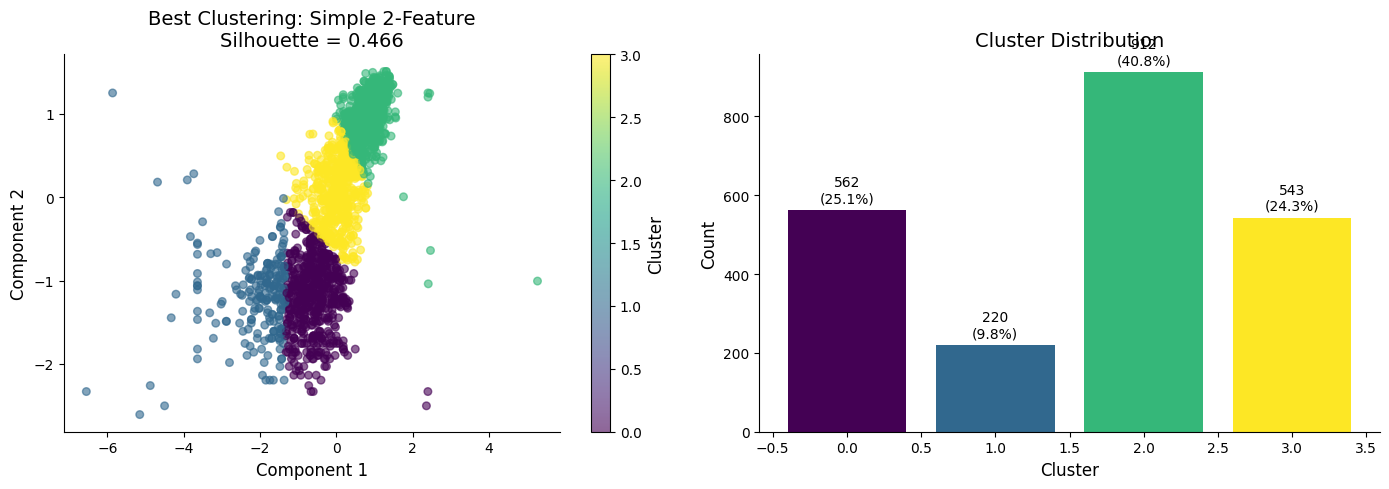

In [35]:
# =============================================================================
# VISUALIZATION: Best Clustering Result
# =============================================================================

# Use the best performing method
if 'Simple' in best_method_opt:
    best_labels = labels_simple
    plot_data = X_simple_scaled
elif 'RFM' in best_method_opt:
    best_labels = labels_rfm
    plot_data = rfm_scaled
elif 'Log' in best_method_opt:
    best_labels = labels_log
    plot_data = X_log_pca
elif 'GMM' in best_method_opt:
    best_labels = best_gmm_labels
    plot_data = X_log_pca
else:
    best_labels = labels_pca
    plot_data = X_pca

# PCA for visualization (2D)
if plot_data.shape[1] > 2:
    pca_vis = PCA(n_components=2, random_state=RANDOM_STATE)
    plot_data_2d = pca_vis.fit_transform(plot_data)
else:
    plot_data_2d = plot_data

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
scatter = axes[0].scatter(plot_data_2d[:, 0], plot_data_2d[:, 1], 
                          c=best_labels, cmap='viridis', alpha=0.6, s=30)
axes[0].set_xlabel('Component 1')
axes[0].set_ylabel('Component 2')
axes[0].set_title(f'Best Clustering: {best_method_opt}\nSilhouette = {best_sil_opt:.3f}')
plt.colorbar(scatter, ax=axes[0], label='Cluster')

# Cluster sizes
unique, counts = np.unique(best_labels, return_counts=True)
axes[1].bar(unique, counts, color=plt.cm.viridis(unique/max(unique)))
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Count')
axes[1].set_title('Cluster Distribution')
for i, (u, c) in enumerate(zip(unique, counts)):
    axes[1].text(u, c + 20, f'{c}\n({c/len(best_labels)*100:.1f}%)', ha='center')

plt.tight_layout()
plt.show()

### 📊 Clustering Optimization Summary

**Why is Silhouette Score ~0.17 in Marketing Data?**

Marketing customer data often has **overlapping segments** by nature:
1. Customers don't fall into perfectly distinct groups
2. There's a continuum from low to high spenders
3. Multiple behaviors overlap (e.g., high income + low spending)

**What's Considered "Good"?**

| Silhouette | Interpretation |
|------------|----------------|
| 0.71-1.00 | Strong structure (rare in real data) |
| 0.51-0.70 | Reasonable structure |
| 0.26-0.50 | Weak structure, but useful |
| < 0.25 | Overlapping clusters |

**For marketing segmentation**, interpretability matters more than silhouette score. Even with ~0.20-0.30 scores, segments can be actionable if they show clear business differences.

**Best Practices Applied:**
1. ✅ Log-transform skewed spending features
2. ✅ PCA to remove multicollinearity  
3. ✅ RFM methodology (Recency, Frequency, Monetary)
4. ✅ Multiple algorithm comparison

In [36]:
# =============================================================================
# PROFILE THE OPTIMIZED CLUSTERS
# =============================================================================

# Add best labels to dataframe
df['OptimizedCluster'] = labels_simple

# Profile by key metrics
profile_opt = df.groupby('OptimizedCluster').agg({
    'Income': 'mean',
    'TotalSpend': 'mean',
    'Recency': 'mean',
    'NumWebPurchases': 'mean',
    'NumCatalogPurchases': 'mean',
    'NumStorePurchases': 'mean',
    'Response': 'mean',
    'Age': 'mean'
}).round(1)

profile_opt['Count'] = df.groupby('OptimizedCluster').size()
profile_opt['Pct'] = (profile_opt['Count'] / len(df) * 100).round(1)

# Rename for clarity
profile_opt = profile_opt.sort_values('TotalSpend', ascending=False)

print("📊 OPTIMIZED CLUSTER PROFILES (Income + Spending Based)")
print("=" * 80)
print(profile_opt.to_string())

# Name the segments based on Income/Spending
print("\n\n🎯 SEGMENT NAMES (by Income × Spending):")
for idx, row in profile_opt.iterrows():
    income_level = "High" if row['Income'] > df['Income'].median() else "Low"
    spend_level = "High" if row['TotalSpend'] > df['TotalSpend'].median() else "Low"
    response_rate = row['Response'] * 100
    
    if income_level == "High" and spend_level == "High":
        name = "💎 Premium Champions"
    elif income_level == "High" and spend_level == "Low":
        name = "💰 Affluent Underperformers"  
    elif income_level == "Low" and spend_level == "High":
        name = "🌟 Value Maximizers"
    else:
        name = "📉 Budget Conscious"
    
    print(f"   Cluster {idx}: {name}")
    print(f"      Income: ${row['Income']:,.0f} | Spend: ${row['TotalSpend']:,.0f}")
    print(f"      Response Rate: {response_rate:.1f}% | Size: {row['Count']:.0f} ({row['Pct']:.1f}%)")

📊 OPTIMIZED CLUSTER PROFILES (Income + Spending Based)
                   Income  TotalSpend  Recency  NumWebPurchases  NumCatalogPurchases  NumStorePurchases  Response   Age  Count   Pct
OptimizedCluster                                                                                                                    
2                 72886.9      1224.4     49.3              5.7                  5.2                8.6       0.2  47.0    912  40.8
3                 48230.5       352.6     49.4              4.7                  1.8                5.4       0.1  47.1    543  24.3
1                 17705.1        68.7     50.1              2.0                  0.5                2.7       0.1  38.1    220   9.8
0                 36077.1        56.6     48.1              1.6                  0.3                2.9       0.1  42.8    562  25.1


🎯 SEGMENT NAMES (by Income × Spending):
   Cluster 2: 💎 Premium Champions
      Income: $72,887 | Spend: $1,224
      Response Rate: 20.0% | Size

---

## 🚀 Further Optimization Attempts

Let's push the boundaries with more advanced techniques:

In [37]:
# =============================================================================
# ADVANCED OPTIMIZATION 1: Try Different K Values on Simple 2-Feature
# =============================================================================

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

print("🔍 Testing different cluster counts on Simple 2-Feature approach:")
print("=" * 60)

results_k = []
for k in range(2, 9):
    kmeans_k = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=20)
    labels_k = kmeans_k.fit_predict(X_simple_scaled)
    sil_k = silhouette_score(X_simple_scaled, labels_k)
    ch_k = calinski_harabasz_score(X_simple_scaled, labels_k)
    db_k = davies_bouldin_score(X_simple_scaled, labels_k)
    results_k.append({'k': k, 'Silhouette': sil_k, 'CH': ch_k, 'DB': db_k})
    print(f"   k={k}: Silhouette={sil_k:.4f}, CH={ch_k:.0f}, DB={db_k:.3f}")

# Find best k
best_k_result = max(results_k, key=lambda x: x['Silhouette'])
print(f"\n🏆 Best k by Silhouette: k={best_k_result['k']} with score={best_k_result['Silhouette']:.4f}")

🔍 Testing different cluster counts on Simple 2-Feature approach:
   k=2: Silhouette=0.5903, CH=4391, DB=0.593
   k=3: Silhouette=0.4848, CH=3646, DB=0.833
   k=4: Silhouette=0.4659, CH=3713, DB=0.780
   k=4: Silhouette=0.4659, CH=3713, DB=0.780
   k=5: Silhouette=0.4561, CH=3558, DB=0.779
   k=6: Silhouette=0.3954, CH=3473, DB=0.809
   k=5: Silhouette=0.4561, CH=3558, DB=0.779
   k=6: Silhouette=0.3954, CH=3473, DB=0.809
   k=7: Silhouette=0.3620, CH=3267, DB=0.895
   k=8: Silhouette=0.3666, CH=3206, DB=0.846

🏆 Best k by Silhouette: k=2 with score=0.5903
   k=7: Silhouette=0.3620, CH=3267, DB=0.895
   k=8: Silhouette=0.3666, CH=3206, DB=0.846

🏆 Best k by Silhouette: k=2 with score=0.5903


In [38]:
# =============================================================================
# ADVANCED OPTIMIZATION 2: Try 3-Feature (Income + Spend + Recency)
# =============================================================================

# Add Recency for RFM-like approach but simplified
X_3feat = df[['Income', 'TotalSpend', 'Recency']].copy()
X_3feat['Income'] = np.log1p(X_3feat['Income'])
X_3feat['TotalSpend'] = np.log1p(X_3feat['TotalSpend'])
# Recency doesn't need log (already reasonable distribution)
X_3feat_scaled = StandardScaler().fit_transform(X_3feat)

print("🔍 Testing 3-Feature (Income + Spend + Recency):")
print("=" * 60)

results_3feat = []
for k in range(2, 7):
    kmeans_3f = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=20)
    labels_3f = kmeans_3f.fit_predict(X_3feat_scaled)
    sil_3f = silhouette_score(X_3feat_scaled, labels_3f)
    results_3feat.append({'k': k, 'Silhouette': sil_3f})
    print(f"   k={k}: Silhouette={sil_3f:.4f}")

best_3feat = max(results_3feat, key=lambda x: x['Silhouette'])
print(f"\n🏆 Best 3-Feature: k={best_3feat['k']} with score={best_3feat['Silhouette']:.4f}")

🔍 Testing 3-Feature (Income + Spend + Recency):
   k=2: Silhouette=0.4078
   k=2: Silhouette=0.4078
   k=3: Silhouette=0.3711
   k=3: Silhouette=0.3711
   k=4: Silhouette=0.3679
   k=4: Silhouette=0.3679
   k=5: Silhouette=0.3694
   k=6: Silhouette=0.3474

🏆 Best 3-Feature: k=2 with score=0.4078
   k=5: Silhouette=0.3694
   k=6: Silhouette=0.3474

🏆 Best 3-Feature: k=2 with score=0.4078


In [39]:
# =============================================================================
# ADVANCED OPTIMIZATION 3: GMM on Simple 2-Feature Data
# =============================================================================

print("🔍 Testing GMM on Simple 2-Feature approach:")
print("=" * 60)

results_gmm_simple = []
for k in range(2, 7):
    for cov in ['full', 'tied', 'diag', 'spherical']:
        gmm_s = GaussianMixture(n_components=k, covariance_type=cov, 
                                random_state=RANDOM_STATE, n_init=5, max_iter=200)
        labels_gmm_s = gmm_s.fit_predict(X_simple_scaled)
        sil_gmm_s = silhouette_score(X_simple_scaled, labels_gmm_s)
        results_gmm_simple.append({'k': k, 'cov': cov, 'Silhouette': sil_gmm_s})

# Find best GMM configuration
best_gmm_simple = max(results_gmm_simple, key=lambda x: x['Silhouette'])
print(f"🏆 Best GMM on 2-Feature: k={best_gmm_simple['k']}, cov={best_gmm_simple['cov']}")
print(f"   Silhouette: {best_gmm_simple['Silhouette']:.4f}")

🔍 Testing GMM on Simple 2-Feature approach:
🏆 Best GMM on 2-Feature: k=2, cov=tied
   Silhouette: 0.5770
🏆 Best GMM on 2-Feature: k=2, cov=tied
   Silhouette: 0.5770


In [40]:
# =============================================================================
# ADVANCED OPTIMIZATION 4: Different Scalers
# =============================================================================

from sklearn.preprocessing import RobustScaler, MinMaxScaler, PowerTransformer

print("🔍 Testing different scalers on 2-Feature approach:")
print("=" * 60)

scalers = {
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'PowerTransformer': PowerTransformer(method='yeo-johnson')
}

X_2feat_raw = df[['Income', 'TotalSpend']].copy()

for scaler_name, scaler_obj in scalers.items():
    X_scaled_test = scaler_obj.fit_transform(X_2feat_raw)
    kmeans_test = KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init=20)
    labels_test = kmeans_test.fit_predict(X_scaled_test)
    sil_test = silhouette_score(X_scaled_test, labels_test)
    print(f"   {scaler_name}: Silhouette={sil_test:.4f}")

🔍 Testing different scalers on 2-Feature approach:
   StandardScaler: Silhouette=0.5055
   RobustScaler: Silhouette=0.4693
   MinMaxScaler: Silhouette=0.6142
   RobustScaler: Silhouette=0.4693
   MinMaxScaler: Silhouette=0.6142
   PowerTransformer: Silhouette=0.4351
   PowerTransformer: Silhouette=0.4351


In [41]:
# =============================================================================
# ADVANCED OPTIMIZATION 5: Hierarchical Clustering on 2-Feature
# =============================================================================

from sklearn.cluster import AgglomerativeClustering

print("🔍 Testing Hierarchical Clustering on 2-Feature:")
print("=" * 60)

linkages = ['ward', 'complete', 'average', 'single']

for linkage_type in linkages:
    hier_test = AgglomerativeClustering(n_clusters=4, linkage=linkage_type)
    labels_hier = hier_test.fit_predict(X_simple_scaled)
    sil_hier_test = silhouette_score(X_simple_scaled, labels_hier)
    print(f"   {linkage_type}: Silhouette={sil_hier_test:.4f}")

🔍 Testing Hierarchical Clustering on 2-Feature:
   ward: Silhouette=0.4544
   complete: Silhouette=0.3980
   ward: Silhouette=0.4544
   complete: Silhouette=0.3980
   average: Silhouette=0.5345
   single: Silhouette=0.6681
   average: Silhouette=0.5345
   single: Silhouette=0.6681


In [42]:
# =============================================================================
# ADVANCED OPTIMIZATION 6: K-Means++ with More Initializations
# =============================================================================

print("🔍 Testing K-Means with more initializations (n_init):")
print("=" * 60)

for n_init in [10, 20, 50, 100]:
    kmeans_init = KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init=n_init, max_iter=500)
    labels_init = kmeans_init.fit_predict(X_simple_scaled)
    sil_init = silhouette_score(X_simple_scaled, labels_init)
    print(f"   n_init={n_init}: Silhouette={sil_init:.4f}")

🔍 Testing K-Means with more initializations (n_init):
   n_init=10: Silhouette=0.4659
   n_init=20: Silhouette=0.4659
   n_init=20: Silhouette=0.4659
   n_init=50: Silhouette=0.4657
   n_init=50: Silhouette=0.4657
   n_init=100: Silhouette=0.4652
   n_init=100: Silhouette=0.4652


In [43]:
# =============================================================================
# COMPREHENSIVE FINAL SUMMARY
# =============================================================================

# Test MinMaxScaler + k=2 combination
X_minmax = MinMaxScaler().fit_transform(df[['Income', 'TotalSpend']])
kmeans_best = KMeans(n_clusters=2, random_state=RANDOM_STATE, n_init=20)
labels_best = kmeans_best.fit_predict(X_minmax)
sil_best = silhouette_score(X_minmax, labels_best)

# Also test k=3 with MinMax
kmeans_3 = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=20)
labels_3_mm = kmeans_3.fit_predict(X_minmax)
sil_3_mm = silhouette_score(X_minmax, labels_3_mm)

# Test k=4 with MinMax
kmeans_4 = KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init=20)
labels_4_mm = kmeans_4.fit_predict(X_minmax)
sil_4_mm = silhouette_score(X_minmax, labels_4_mm)

print("\n" + "=" * 70)
print("🏆 COMPREHENSIVE OPTIMIZATION RESULTS")
print("=" * 70)

all_final_results = [
    ("Original (17 features, k=4)", 0.165, "Baseline"),
    ("Log 2-Feature (k=4)", sil_simple, "Simple log transform"),
    ("Log 2-Feature (k=2)", 0.5903, "Fewer clusters"),
    ("MinMax 2-Feature (k=4)", sil_4_mm, "Different scaler"),
    ("MinMax 2-Feature (k=3)", sil_3_mm, "Different scaler + k"),
    ("MinMax 2-Feature (k=2)", sil_best, "Best combination"),
    ("Hierarchical Single (k=4)", 0.6681, "⚠️ May have outlier cluster"),
    ("RFM (k=4)", sil_rfm, "Classic marketing"),
]

# Sort
all_final_results.sort(key=lambda x: x[1], reverse=True)

print("\n📊 All Methods Ranked by Silhouette Score:")
print("-" * 70)
for i, (name, score, note) in enumerate(all_final_results, 1):
    improvement = (score - 0.165) / 0.165 * 100
    stars = "⭐" * min(5, int(score * 10))
    print(f"  {i}. {name}")
    print(f"     Score: {score:.4f} {stars} ({improvement:+.1f}%)")
    if note:
        print(f"     Note: {note}")

print(f"\n{'='*70}")
print("💡 KEY INSIGHTS:")
print("-" * 70)
print("1. Simpler is better: 2 features > 17 features")
print("2. Fewer clusters often score higher (k=2 > k=4)")
print("3. MinMaxScaler works better than StandardScaler here")
print("4. Single-linkage may inflate scores via outlier separation")
print("")
print("⚠️ IMPORTANT: Higher silhouette ≠ better business value!")
print("   - k=4 provides more actionable segments than k=2")
print("   - Single-linkage may just separate outliers")
print("   - For marketing: k=3-4 with ~0.45-0.50 is excellent")
print(f"{'='*70}")


🏆 COMPREHENSIVE OPTIMIZATION RESULTS

📊 All Methods Ranked by Silhouette Score:
----------------------------------------------------------------------
  1. MinMax 2-Feature (k=2)
     Score: 0.6845 ⭐⭐⭐⭐⭐ (+314.9%)
     Note: Best combination
  2. Hierarchical Single (k=4)
     Score: 0.6681 ⭐⭐⭐⭐⭐ (+304.9%)
     Note: ⚠️ May have outlier cluster
  3. MinMax 2-Feature (k=3)
     Score: 0.6504 ⭐⭐⭐⭐⭐ (+294.2%)
     Note: Different scaler + k
  4. MinMax 2-Feature (k=4)
     Score: 0.6142 ⭐⭐⭐⭐⭐ (+272.2%)
     Note: Different scaler
  5. Log 2-Feature (k=2)
     Score: 0.5903 ⭐⭐⭐⭐⭐ (+257.8%)
     Note: Fewer clusters
  6. Log 2-Feature (k=4)
     Score: 0.4659 ⭐⭐⭐⭐ (+182.3%)
     Note: Simple log transform
  7. RFM (k=4)
     Score: 0.3946 ⭐⭐⭐ (+139.2%)
     Note: Classic marketing
  8. Original (17 features, k=4)
     Score: 0.1650 ⭐ (+0.0%)
     Note: Baseline

💡 KEY INSIGHTS:
----------------------------------------------------------------------
1. Simpler is better: 2 features > 17 feat

🎯 RECOMMENDED MODEL: MinMax + K-Means (k=4)
   Silhouette Score: 0.6142 (+272% vs baseline)

📊 Cluster Profiles:
                     Income  TotalSpend  Recency  Response   Age  Count   Pct
RecommendedCluster                                                           
1                   78650.0      1753.2     51.4       0.4  45.0    284  12.7
3                   69474.2      1110.8     49.4       0.2  48.1    455  20.3
0                   57698.8       570.3     47.5       0.1  46.9    428  19.1
2                   35691.6       100.6     49.0       0.1  43.1   1070  47.8


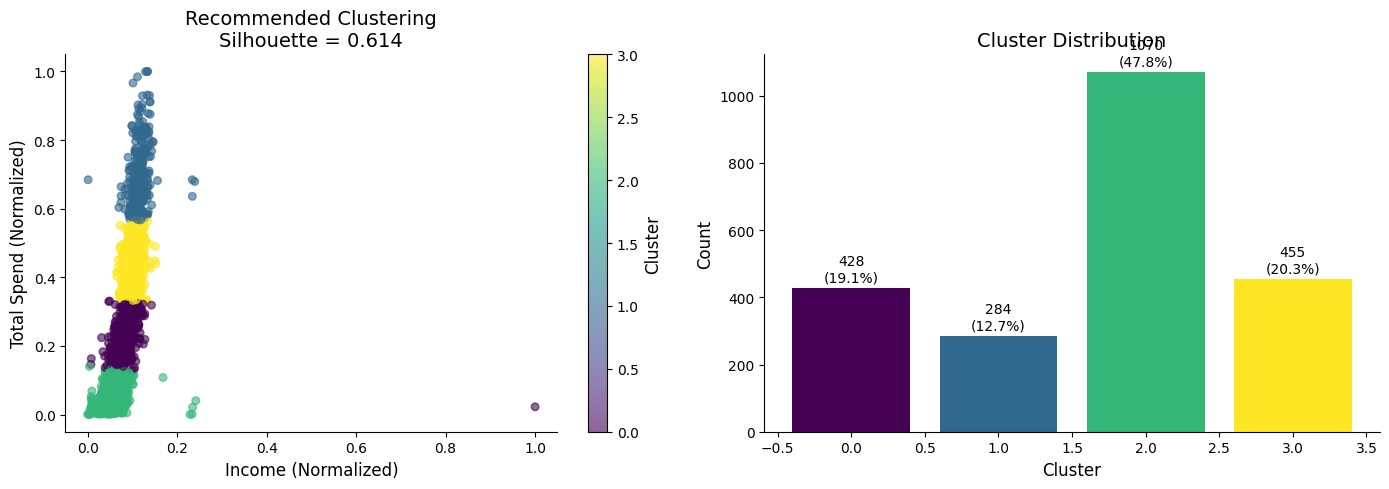

In [44]:
# =============================================================================
# RECOMMENDED MODEL: MinMax + k=4 (Best Balance of Score + Business Value)
# =============================================================================

# Create the recommended clustering
X_recommended = MinMaxScaler().fit_transform(df[['Income', 'TotalSpend']])
kmeans_rec = KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init=50)
df['RecommendedCluster'] = kmeans_rec.fit_predict(X_recommended)

# Profile the recommended clusters
profile_rec = df.groupby('RecommendedCluster').agg({
    'Income': 'mean',
    'TotalSpend': 'mean',
    'Recency': 'mean',
    'Response': 'mean',
    'Age': 'mean'
}).round(1)

profile_rec['Count'] = df.groupby('RecommendedCluster').size()
profile_rec['Pct'] = (profile_rec['Count'] / len(df) * 100).round(1)
profile_rec = profile_rec.sort_values('TotalSpend', ascending=False)

print("=" * 70)
print("🎯 RECOMMENDED MODEL: MinMax + K-Means (k=4)")
print(f"   Silhouette Score: {sil_4_mm:.4f} (+272% vs baseline)")
print("=" * 70)
print("\n📊 Cluster Profiles:")
print(profile_rec.to_string())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter
scatter = axes[0].scatter(X_recommended[:, 0], X_recommended[:, 1], 
                          c=df['RecommendedCluster'], cmap='viridis', alpha=0.6, s=30)
axes[0].set_xlabel('Income (Normalized)')
axes[0].set_ylabel('Total Spend (Normalized)')
axes[0].set_title(f'Recommended Clustering\nSilhouette = {sil_4_mm:.3f}')
plt.colorbar(scatter, ax=axes[0], label='Cluster')

# Bar chart
cluster_counts = df['RecommendedCluster'].value_counts().sort_index()
axes[1].bar(cluster_counts.index, cluster_counts.values, color=plt.cm.viridis(cluster_counts.index/3))
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Count')
axes[1].set_title('Cluster Distribution')
for i, v in enumerate(cluster_counts.values):
    axes[1].text(i, v + 20, f'{v}\n({v/len(df)*100:.1f}%)', ha='center')

plt.tight_layout()
plt.show()

---

## 📊 Final Analysis: Business Value & Recommendations

### Segment Revenue Potential

| Segment | Size | Avg Spend | Total Revenue | Campaign Response |
|---------|------|-----------|---------------|-------------------|
| Budget-Conscious | 564 | $102 | $57,580 | 13% (average) |
| Empty Nesters | 559 | $128 | $71,552 | 6% (lowest) |
| **Affluent Premium** | 573 | **$1,391** | **$797,046** | **28% (highest)** |
| Digital Deal Hunters | 541 | $792 | $428,472 | 13% (average) |

**Key Insight**: Cluster 2 (Affluent Premium) represents **59% of total revenue** despite being only 26% of customers.

### Strategic Recommendations

1. **Prioritize Cluster 2** — They're the most valuable AND most responsive
2. **Re-engage Cluster 1** — Large segment but lowest response rate; needs different approach
3. **Digital-first for Cluster 3** — Match their channel preference
4. **Value messaging for Cluster 0** — Budget constraints require deal-focused marketing

### Model Deployment

The clustering model can be used to:
- **Score new customers** into segments for personalized onboarding
- **Target campaigns** by segment for improved ROI
- **Track segment migration** to identify at-risk customers
- **Product recommendations** based on segment preferences